In [110]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_data_template
from src.features.games_detailed import GameDetailedFeatures

In [162]:
data = load_data_template(season=False)
game_detail_feat = GameDetailedFeatures(default_lags=1)
data = game_detail_feat.per_team_wrapper(data, game_detail_feat.season_detail_features_summed)
data.dropna(inplace=True)
print(data.shape)
data.sample()

(981, 59)


,Season,team_a,team_b,in_target,game_set,a_win,DayNum,FGM_season_team_a,FGA_season_team_a,FGM3_season_team_a,...,FGA3_season_team_b_lag-1,FTM_season_team_b_lag-1,FTA_season_team_b_lag-1,OR_season_team_b_lag-1,DR_season_team_b_lag-1,Ast_season_team_b_lag-1,TO_season_team_b_lag-1,Stl_season_team_b_lag-1,Blk_season_team_b_lag-1,PF_season_team_b_lag-1
10266,2003,1139,1280,False,0,True,137.0,1116.0,2427.0,318.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss


cat_cols = ['team_a', 'team_b', 'game_set']
X = data.drop(['Season', 'a_win', 'in_target', 'DayNum'], axis=1)
X_enc = OneHotEncoder(categorical_features=[c in cat_cols for c in X.columns]).fit_transform(X).todense()
y = data[['a_win']].astype(int)

kf = KFold(n_splits=15, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X_enc):
    X_tr, y_tr = X_enc[tr_i], y.iloc[tr_i]
    X_t, y_t = X_enc[t_i], y.iloc[t_i]
    xgb = XGBClassifier()
    xgb.fit(X_tr, y_tr.values.reshape(-1))
    preds = xgb.predict_proba(X_t)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.5923870390450413
0.5806730145193411
0.6861950927837328
0.5342072005750556
0.6769934849757137
0.672553870714072
0.6529070699444184
0.5516665408817621
0.6024962191398328
0.5904589021721711
0.619268482694259
0.6741583911272195
0.5903896059840917
0.6526937479869678
0.5811013927826515
Metric Mean: 0.62 (0.05)


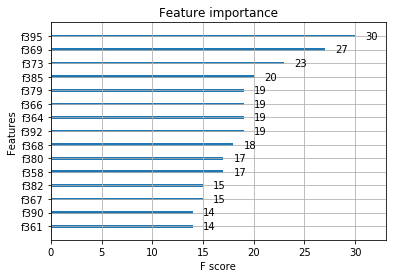

In [166]:
from xgboost import plot_importance

plt.figure(figsize=(20,4))
plot_importance(xgb, max_num_features=15)
plt.show()